In [1]:
import warnings
warnings.filterwarnings(action='ignore') # To show code clearly

In [2]:
import os
import csv
import scipy
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import GEOparse
gse = GEOparse.get_GEO("GSE39445", annotate_gpl='GPL15331', silent=True)

### Pre-processing

In [4]:
# Blood transcriptome data
sample_info_dict = {}
try : 
    for gsm_name, gsm in gse.gsms.items():
        if len(gsm.metadata["title"][0].split('_')) < 4 : 
            subject = gsm.metadata["title"][0].split('_')[0]
            timepoint = gsm.metadata["title"][0].split('_')[2]
        else :
            subject = gsm.metadata["title"][0].split('_')[1]
            timepoint = gsm.metadata["title"][0].split('_')[3]
        for i in gsm.metadata["characteristics_ch1"]:
            if i.split(': ')[0] in ['sleepprotocol', 'hoursawake', 'timesampletaken', 'circadianphase']:
                vars()[i.split(': ')[0]] = i.split(': ')[1]
        sample_info_dict[gsm.metadata["geo_accession"][0]] = [subject, sleepprotocol, timepoint, hoursawake, timesampletaken, circadianphase]     
except:
    print(gsm_name)
col = ['subject', 'sleepprotocol', 'timepoint', 'hoursawake', 'timesampletaken', 'circadianphase']    
sample_info = pd.DataFrame.from_dict(sample_info_dict, orient='index', columns=col)
sample_info.loc['GSM969077']['circadianphase'] = '0' # manual curation

In [5]:
# Annotation table
gpl = gse.gpls['GPL15331'].table.dropna(subset=['GENE_SYMBOL'])
annot_table = gsm.annotate(gpl, annotation_column="GENE_SYMBOL")
annot_table = annot_table.drop(['VALUE'], axis=1)
annot_table = annot_table.set_index('ID_REF')

In [6]:
# Sleep condition groups
SE = sample_info[sample_info['sleepprotocol']=='Sleep Extension'].index.tolist()
SR = sample_info[sample_info['sleepprotocol']=='Sleep Restriction'].index.tolist()

SE_df = gse.pivot_samples('VALUE')[SE] # Quantile normalized signal intensity
SR_df = gse.pivot_samples('VALUE')[SR]

In [7]:
annot_dict = {k:v['GENE_SYMBOL'] for k, v in annot_table.to_dict('index').items()}

SE_df.rename(index=annot_dict, inplace=True)
SE_df.drop((i for i in SE_df.index if type(i)==int), inplace=True)
SE_df = SE_df.groupby(SE_df.index).mean() #19541

SR_df.rename(index=annot_dict, inplace=True)
SR_df.drop((i for i in SR_df.index if type(i)==int), inplace=True)
SR_df = SR_df.groupby(SR_df.index).mean() #19541

In [8]:
def fillna(data):
    df = pd.DataFrame(data, columns=['T'+str(i+1) for i in range(10)])
    df = df.T.interpolate()
    df = df.fillna(method='ffill') #fillna with previous time value
    df = df.fillna(method='bfill') #fillna with next time value
    return df.T

In [25]:
# Subject dataframe
for subject in set(sample_info['subject']) :
    for protocol in ["Sleep Extension", "Sleep Restriction"]:
        df = sample_info[(sample_info['sleepprotocol']==protocol)&(sample_info['subject']==subject)]
        if protocol == 'Sleep Extension' :
            vars()[subject+'_SE'] = SE_df[df.index]
            vars()[subject+'_SE'].columns = df.timepoint
        elif protocol == 'Sleep Restriction' :
            vars()[subject+'_SR'] = SR_df[df.index]
            vars()[subject+'_SR'].columns = df.timepoint
# Sleep Extension data is mission in Subjects AF0079, AF0091.
subjects = list(set(sample_info['subject']) - set(['AF0079','AF0091']))

for subject in set(sample_info['subject']) :
    for protocol in ["SE", "SR"]:
        vars()[subject+'_'+protocol+'_filled'] = fillna(vars()[subject+'_'+protocol])

### DEG search

In [26]:
# Mixed-model ANOVA
import pingouin as pg

DF = pd.DataFrame()
for subject in subjects:
    df = sample_info[['subject','sleepprotocol','timepoint']]
    df_se = pd.merge(df[(df['subject']==subject)&(df['sleepprotocol']=='Sleep Extension')], vars()[subject+'_SE_filled'].T, how='outer', left_on='timepoint', right_index=True)
    df_se['subject'] = subject + '_SE'
    df_se['sleepprotocol'] = df_se['sleepprotocol'].fillna('Sleep Extension')

    df_sr = pd.merge(df[(df['subject']==subject)&(df['sleepprotocol']=='Sleep Restriction')], vars()[subject+'_SR_filled'].T, how='outer', left_on='timepoint', right_index=True)
    df_sr['subject'] = subject + '_SR'
    df_sr['sleepprotocol'] = df_sr['sleepprotocol'].fillna('Sleep Restriction')

    DF = pd.concat([DF, df_se, df_sr])

In [11]:
DEG_anova = []
if os.path.isfile('../data/SR-GSE39445/ANOVA762.csv'):
    with open('../data/SR-GSE39445/ANOVA762.csv') as fr:
        reader = csv.reader(fr)
        for line in reader:
            DEG_anova.append(line)
    DEG_anova = DEG_anova[0]
    print(len(DEG_anova))
else :
    for gene in DF.columns[3:]:
        results = pg.mixed_anova(dv=gene, between='sleepprotocol', within='timepoint', subject='subject', data=DF[['subject','sleepprotocol','timepoint',gene]])
        reject, corrected_pval = pg.multicomp(results['p-unc'], method='fdr_bh')
        if corrected_pval[2] < 0.05:
            DEG_anova.append(gene)
    print(len(DEG_anova)) #762

762


### Stationary test

In [12]:
# Stationary test (Augmented Dickey-Fuller test)
from statsmodels.tsa.stattools import adfuller

if os.path.isfile('../data/SR-GSE39445/nonstationary.csv'):
    nonstationary_list = []
    with open('../data/SR-GSE39445/nonstationary.csv', 'r') as fr :
        reader = csv.reader(fr)
        for line in reader:
            nonstationary_list.append(line) 
    nonstationary_list = nonstationary_list[0]
    print(len(nonstationary_list))
else :
    nonstationary = dict()
    for subject in set(sample_info['subject']) :
        df = vars()[subject+'_SE']
        if len(df.columns) == 10 :  # samples should have all time-points
            sns = []
            try :
                for i in df.index:
                    if adfuller(df.loc[i])[1] >= 0.05 :
                        sns.append(i)
                nonstationary[subject] = sns
            except : print("X",subject, i)

    nonstationary_list = set.union(*map(set, nonstationary.values()))
    len(nonstationary_list) #19529

19529


### Oscillation test

In [13]:
# Cosinor analysis - 24 periodicity
from CosinorPy import cosinor, cosinor1

if os.path.isfile('../data/SR-GSE39445/oscillation_SE.csv') & os.path.isfile('../data/SR-GSE39445/oscillation_SR.csv') :
    oscillation_SE = []; oscillation_SR = []
    with open('../data/SR-GSE39445/oscillation_SE.csv','r') as fr:
        reader = csv.reader(fr)
        for line in reader:
            oscillation_SE.append(line)
    oscillation_SE = oscillation_SE[0]
    
    with open('../data/SR-GSE39445/oscillation_SR.csv','r') as fr:
        reader = csv.reader(fr)
        for line in reader:
            oscillation_SR.append(line)
    oscillation_SR = oscillation_SR[0]
    print(len(oscillation_SE), len(oscillation_SR)) #17783, 17912

else :
    cosinor_dict = {}
    for subject in set(sample_info['subject']) :
        cosinor_dict[subject] = {}
        for group in ["SE","SR"]:
            cosinor_dict[subject][group] = pd.DataFrame()
            if len(vars()[subject+"_"+group].columns) == 0 : pass
            else :
                df = fillna(vars()[subject+"_"+group])
                for i in vars()[subject+"_"+group].index :
                    cosinor_df = pd.DataFrame({'x':np.linspace(0,30,10), 'y':df.loc[i].values, 'test':['test1']*10})
                    results = cosinor.fit_group(cosinor_df, period=24, plot=False)
                    df_best_models = cosinor.get_best_models(cosinor_df, results)
                    df_best_models['test'] = i
                    cosinor_dict[subject][group] = pd.concat([cosinor_dict[subject][group], df_best_models])
                    
    for group in ["SE","SR"]:
        vars()["oscillation_"+group] = []
        for subject, cosinor_res in cosinor_dict.items():
            if len(cosinor_res[group]) != 0 :
                vars()["oscillation_"+group].extend(cosinor_res[group][cosinor_res[group]['p'] < 0.05]['test'])

oscillation_genes = set(oscillation_SE).intersection(set(nonstationary_list))
print(len(oscillation_genes)) #17771

17783 17912
17771


### Network construction

In [14]:
# Gene co-expressed network
G = nx.Graph()
DEGs = list(set(oscillation_genes).intersection(set(DEG_anova))) # You can get DEGs from ./data/SR-GSE39445/DEG732b.csv
G.add_nodes_from(DEGs) #732

In [15]:
# Phase dataframe
protocols = []
for time in ['T'+str(i+1) for i in range(10)]:
    for sleep in ['Sleep Extension', 'Sleep Restriction']:
        if sleep == 'Sleep Extension': protocol = "SE"
        elif sleep == 'Sleep Restriction': protocol = "SR"
        name = protocol+'_'+time
        vars()[name] = sample_info[(sample_info.sleepprotocol == sleep) & (sample_info.timepoint == time)].index
        vars()[name+'_df'] = vars()[protocol+'_df'][vars()[name]].loc[DEGs]
        protocols.append(name)

In [16]:
# Make the edges
from tqdm import tqdm

for protocol in protocols:
    if os.path.isfile('../data/SR-GSE39445/network/{}_edges.csv'.format(protocol)):
        vars()[protocol+'_edges'] = []
        with open('../data/SR-GSE39445/network/{}_edges.csv'.format(protocol)) as fr:
            reader = csv.reader(fr)
            for line in reader:
                vars()[protocol+'_edges'].append(line)
        vars()[protocol+'_edges'] = vars()[protocol+'_edges'][0]
        vars()[protocol+'_filtered_edge'] = [eval(edge) for edge in vars()[protocol+'_edges'] if edge.split(', ')[-1][:-1] != '0']
        
    else:
        df = vars()[protocol+'_df']
        edges = []
        for i in tqdm(range(len(df.index))):
            for j in range(len(df.index)):
                if i < j :
                    r, p = scipy.stats.pearsonr(df.iloc[i], df.iloc[j])
                    if p < 0.05:
                        edges.append((df.index[i], df.index[j], r)) 
                    else: edges.append((df.index[i], df.index[j], 0))
        vars()[protocol+'_edges'] = edges
        vars()[protocol+'_filtered_edge'] = [edge for edge in vars()[protocol+'_edges'] if edge[2] != 0]
        
    globals()[protocol+'_graph'] = G.copy() # nodes : 732
    globals()[protocol+'_graph'].add_weighted_edges_from(vars()[protocol+'_filtered_edge'])

In [18]:
# Subject networks
for protocol in protocols:
    if protocol[:2] == 'SE' : sleepprotocol = 'Sleep Extension'
    elif protocol[:2] == 'SR' : sleepprotocol = 'Sleep Restriction'
    time = protocol.split('_')[1]
    for subject in subjects:
        vars()[protocol+'_'+subject] = []
        if os.path.isfile('../data/SR-GSE39445/network/subjects/{}.csv'.format(protocol+'_'+subject)):
            with open('../data/SR-GSE39445/network/subjects/{}.csv'.format(protocol+'_'+subject)) as fr:
                reader = csv.reader(fr)
                for line in reader:
                    vars()[protocol+'_'+subject].append(line)
            vars()[protocol+'_'+subject] = vars()[protocol+'_'+subject][0]
            vars()[protocol+'_'+subject] = [eval(edge) for edge in vars()[protocol+'_'+subject] if edge.split(', ')[-1][:-1] != '0']

        else:
            df = vars()[protocol+'_df']
            sample_name = sample_info[(sample_info.subject==subject)&(sample_info.sleepprotocol==sleepprotocol)&(sample_info.timepoint==time)].index
            if len(sample_name) > 0 :
                for g_i, g_j, r in vars()[protocol+'_filtered_edge']:
                    ia = df.loc[g_i, ~df.columns.str.contains(sample_name[0])].tolist()
                    ib = df.loc[g_j, ~df.columns.str.contains(sample_name[0])].tolist()
                    r_new, p_new = scipy.stats.pearsonr(ia, ib)
                    if (p_new < 0.05) & (np.abs(r)-np.abs(r_new) > 0):
                        vars()[protocol+'_'+subject].append((g_i, g_j, r_new))
            else :
                vars()[protocol+'_'+subject] = vars()[protocol+'_filtered_edge']

        vars()['G_'+protocol+'_'+subject] = G.copy() # nodes : 732
        vars()['G_'+protocol+'_'+subject].add_weighted_edges_from(vars()[protocol+'_'+subject])

### Network topology analysis

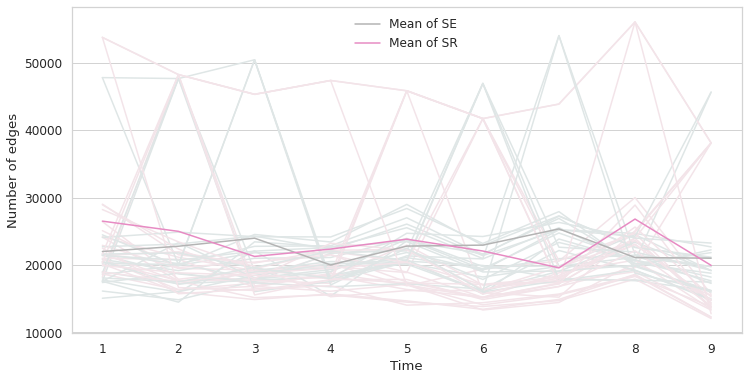

In [30]:
# Edge count
Edge_subject = {'SE':{s:[] for s in subjects},'SR':{s:[] for s in subjects}}
for protocol in protocols:
    for subject in subjects:
        Edge_subject[protocol[:2]][subject].append(len(vars()['G_'+protocol+'_'+subject].edges()))
            
sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)
Edge_df_SE = pd.DataFrame.from_dict(Edge_subject['SE'], orient='index', columns=np.arange(0,40,4))
Edge_df_SR = pd.DataFrame.from_dict(Edge_subject['SR'], orient='index', columns=np.arange(0,40,4))
for subject in set(sample_info.subject):
    if subject not in ['AF0091','AF0079']:
        plt.plot(Edge_df_SE.loc[subject,:][range(0,36,4)], color='#DFE6E6')
        plt.plot(Edge_df_SR.loc[subject,:][range(0,36,4)], color='#F3E4E9')
plt.plot(Edge_df_SE[range(0,36,4)].mean(),color=sns.color_palette('Set2')[-1], label='Mean of SE')
plt.plot(Edge_df_SR[range(0,36,4)].mean(),color=sns.color_palette('Set2')[3], label='Mean of SR')
plt.xticks(np.arange(0,36,4), labels=range(1,10))
plt.grid(True, axis='y', color='lightgrey')
plt.xlabel('Time'); plt.ylabel('Number of edges')
plt.legend(frameon=False)
plt.show()

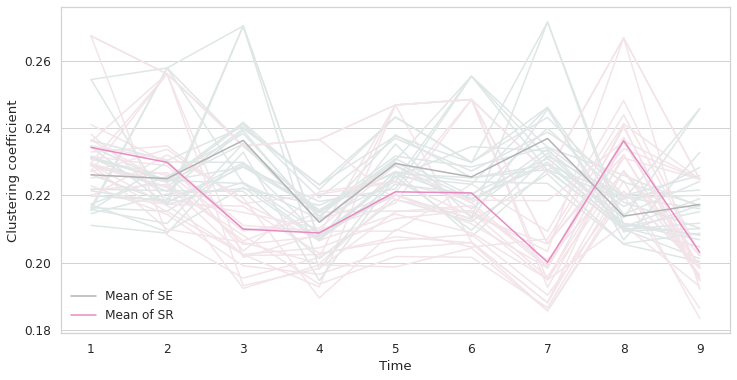

In [31]:
# Clustering coefficient
CC_subjects = {'SE':{s:[] for s in subjects},'SR':{s:[] for s in subjects}}
for protocol in protocols:
    for subject in subjects:
        CC_subjects[protocol[:2]][subject].append(np.average(list(nx.clustering(vars()['G_'+protocol+'_'+subject], weight='weight').values())))
    
sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)
CC_df_SE = pd.DataFrame.from_dict(CC_subjects['SE'], orient='index', columns=np.arange(0,40,4))
CC_df_SR = pd.DataFrame.from_dict(CC_subjects['SR'], orient='index', columns=np.arange(0,40,4))
for subject in subjects:
    plt.plot(CC_df_SE.loc[subject,:][range(0,36,4)], color='#DFE6E6')
    plt.plot(CC_df_SR.loc[subject,:][range(0,36,4)], color='#F3E4E9')
plt.plot(CC_df_SE[range(0,36,4)].mean(),color=sns.color_palette('Set2')[-1], label='Mean of SE')
plt.plot(CC_df_SR[range(0,36,4)].mean(),color=sns.color_palette('Set2')[3], label='Mean of SR')
plt.xticks(np.arange(0,36,4), labels=range(1,10))
plt.grid(True, axis='y', color='lightgrey')
plt.xlabel('Time'); plt.ylabel('Clustering coefficient')
plt.legend(frameon=False)
plt.show()

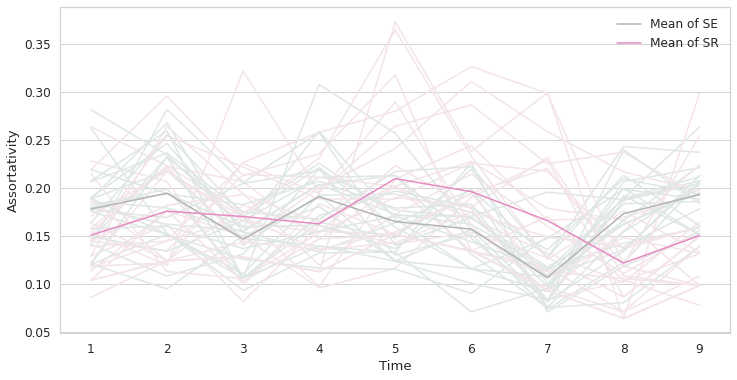

In [32]:
# Assortativity
ASS_subjects = {'SE':{s:[] for s in subjects},'SR':{s:[] for s in subjects}}
for protocol in protocols:
    for subject in subjects:
        ASS_subjects[protocol[:2]][subject].append(nx.degree_pearson_correlation_coefficient(vars()['G_'+protocol+'_'+subject], weight='weight'))
            
sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)
ASS_df_SE = pd.DataFrame.from_dict(ASS_subjects['SE'], orient='index', columns=np.arange(0,40,4))
ASS_df_SR = pd.DataFrame.from_dict(ASS_subjects['SR'], orient='index', columns=np.arange(0,40,4))
for subject in subjects:
    plt.plot(ASS_df_SE.loc[subject,:][range(0,36,4)], color='#DFE6E6')
    plt.plot(ASS_df_SR.loc[subject,:][range(0,36,4)], color='#F3E4E9')
plt.plot(ASS_df_SE[range(0,36,4)].mean(),color=sns.color_palette('Set2')[-1], label='Mean of SE')
plt.plot(ASS_df_SR[range(0,36,4)].mean(),color=sns.color_palette('Set2')[3], label='Mean of SR')
plt.xticks(np.arange(0,36,4), labels=range(1,10))
plt.grid(True, axis='y', color='lightgrey')
plt.xlabel('Time'); plt.ylabel('Assortativity')
plt.legend(frameon=False)
plt.show()

In [33]:
# Graph entropy for weighted graph
from __future__ import division

def centrality_distribution(G):
    centrality = nx.eigenvector_centrality_numpy(G, weight='weight').values()
    centrality = list(centrality)
    centrality = np.array(centrality) / sum(centrality)
    return centrality

def graph_entropy(dist):
    dist = np.asarray(dist)
    ent = np.nansum( dist *  np.log2( 1/dist ) )
    return ent

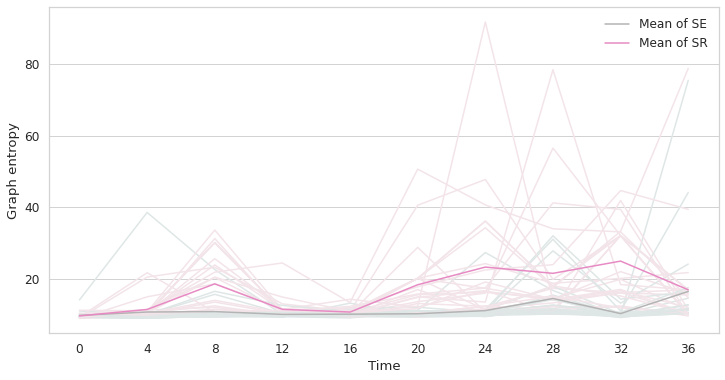

In [34]:
# Graph entropy
GE_subjects = {'SE':{s:[] for s in subjects},'SR':{s:[] for s in subjects}}
for protocol in protocols:
    for subject in subjects:
        d = centrality_distribution(vars()['G_'+protocol+'_'+subject])
        GE_subjects[protocol[:2]][subject].append(graph_entropy(d))
            
sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)
GE_df_SE = pd.DataFrame.from_dict(GE_subjects['SE'], orient='index', columns=np.arange(0,40,4))
GE_df_SR = pd.DataFrame.from_dict(GE_subjects['SR'], orient='index', columns=np.arange(0,40,4))
for subject in subjects:
    plt.plot(GE_df_SE.loc[subject,:], color='#DFE6E6')
    plt.plot(GE_df_SR.loc[subject,:], color='#F3E4E9')
plt.plot(GE_df_SE.mean(),color=sns.color_palette('Set2')[-1], label='Mean of SE')
plt.plot(GE_df_SR.mean(),color=sns.color_palette('Set2')[3], label='Mean of SR')
plt.xticks(np.arange(0,40,4))
plt.grid(True, axis='y', color='lightgrey')
plt.xlabel('Time'); plt.ylabel('Graph entropy')
plt.legend(frameon=False)
plt.show()

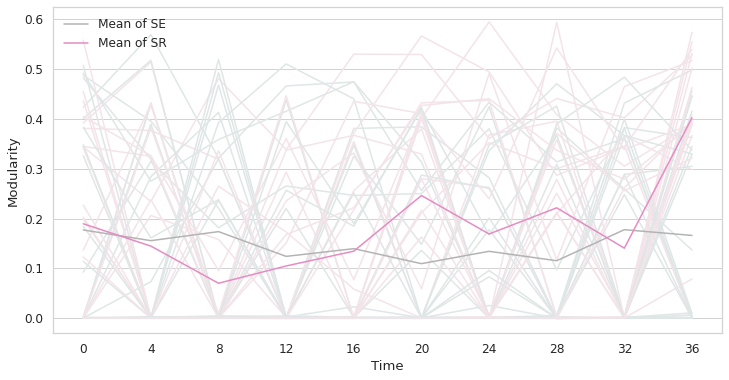

In [35]:
# Modularity
MD_subjects = {'SE':{s:[] for s in subjects},'SR':{s:[] for s in subjects}}
for protocol in protocols:
    for subject in subjects:
        graph = vars()['G_'+protocol+'_'+subject]
        MD_subjects[protocol[:2]][subject].append(nx.community.modularity(graph, nx.community.label_propagation_communities(graph)))
            
sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.1)
MD_df_SE = pd.DataFrame.from_dict(MD_subjects['SE'], orient='index', columns=np.arange(0,40,4))
MD_df_SR = pd.DataFrame.from_dict(MD_subjects['SR'], orient='index', columns=np.arange(0,40,4))
for subject in subjects:   
    plt.plot(MD_df_SE.loc[subject,:], color='#DFE6E6')
    plt.plot(MD_df_SR.loc[subject,:], color='#F3E4E9')
plt.plot(MD_df_SE.mean(),color=sns.color_palette('Set2')[-1], label='Mean of SE')
plt.plot(MD_df_SR.mean(),color=sns.color_palette('Set2')[3], label='Mean of SR')
plt.xticks(np.arange(0,40,4))
plt.grid(True, axis='y', color='lightgrey')
plt.xlabel('Time'); plt.ylabel('Modularity')
plt.legend(frameon=False)
plt.show()

### Sleep homeostasis - Circadian effects

In [38]:
# Linear mixed-effects model

import math
from scipy.optimize import curve_fit

def df_interpolate(dic):
    df = pd.DataFrame.from_dict(dic, orient='index').T
    df = df.replace(0,np.nan).interpolate()
    df = df.T[df.isna().sum() != 10]
    for i in df[df[0].isna()].index:
        n = df.loc[i].isna().sum()
        df.loc[i][0:n] = df.loc[i][n]
    return df

def func(x, a, b, c, d, e):
    return a + b*np.log(x) + c*np.cos(2*math.pi*(x+d)/24) + e

def curve_fitting(subject_dict):
    dict_df = {'SE':pd.DataFrame(subject_dict['SE']).T, 'SR':pd.DataFrame(subject_dict['SR']).T}
    Hparam = {'SE':{}, 'SR':{}}; std_err = {'SE':{}, 'SR':{}}
    for subject in set(dict_df['SE'].index).intersection(set(dict_df['SR'].index)) :
        Hparam['SE'][subject] = None; Hparam['SR'][subject] = None;
        std_err['SE'][subject] = None; std_err['SR'][subject] = None;
        for protocol in ['SE','SR']:
            xdata = np.array([0,4,8,12,16,20,24,28,32,36]) + 1
            ydata = dict_df[protocol].loc[subject].tolist()
            popt, pcov = curve_fit(func, xdata, ydata, absolute_sigma=True)
            Hparam[protocol][subject] = popt
            std_err[protocol][subject] = np.sqrt(np.diag(pcov))
    return Hparam, std_err

In [41]:
Hparam_CC, std_err_ = curve_fitting(CC_subjects)
Hparam_ASS, std_err_ = curve_fitting(ASS_subjects)
Hparam_GE, std_err_ = curve_fitting(GE_subjects)
Hparam_MD, std_err_ = curve_fitting(MD_subjects)

Hparam_GE['SE'] = {k:v/100 for k,v in Hparam_GE['SE'].items()} #normalize
Hparam_GE['SR'] = {k:v/100 for k,v in Hparam_GE['SR'].items()}

In [46]:
print(np.mean([c[1] for s, c in Hparam_CC['SE'].items()]), np.mean([c[1] for s, c in Hparam_CC['SR'].items()]))
print(np.mean([c[1] for s, c in Hparam_ASS['SE'].items()]), np.mean([c[1] for s, c in Hparam_ASS['SR'].items()]))
print(np.mean([c[1] for s, c in Hparam_GE['SE'].items()]), np.mean([c[1] for s, c in Hparam_GE['SR'].items()]))
print(np.mean([c[1] for s, c in Hparam_MD['SE'].items()]), np.mean([c[1] for s, c in Hparam_MD['SR'].items()]))

-0.0009831239246457736 -0.004361562255980986
-0.011582418247038989 -0.004463718608105343
0.009733192545126277 0.04476484907503219
-0.01270695936858799 0.02984848792861251


In [47]:
print(np.mean([c[2] for s, c in Hparam_CC['SE'].items()]), np.mean([c[2] for s, c in Hparam_CC['SR'].items()]))
print(np.mean([c[2] for s, c in Hparam_ASS['SE'].items()]), np.mean([c[2] for s, c in Hparam_ASS['SR'].items()]))
print(np.mean([c[2] for s, c in Hparam_GE['SE'].items()]), np.mean([c[2] for s, c in Hparam_GE['SR'].items()]))
print(np.mean([c[2] for s, c in Hparam_MD['SE'].items()]), np.mean([c[2] for s, c in Hparam_MD['SR'].items()]))

0.004198228678110853 0.004167446893086904
-0.022989435601971742 0.01716753299728933
-0.0034210739032337987 -0.0026918945847561027
-0.005585698754546378 0.047775665321532386


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ASS_SE v.s. ASS_SR: t-test independent samples, P_val=1.742e-01 stat=-1.380e+00
CC_SE v.s. CC_SR: t-test independent samples, P_val=1.344e-04 stat=4.167e+00
GE_SE v.s. GE_SR: t-test independent samples, P_val=2.501e-05 stat=-4.686e+00
MD_SE v.s. MD_SR: t-test independent samples, P_val=1.978e-02 stat=-2.415e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ASS_SE v.s. ASS_SR: t-test independent samples, P_val=5.539e-05 stat=-4.443e+00
CC_SE v.s. CC_SR: t-test independent samples, P_val=9.895e-01 stat=1.322e-02
GE_SE v.s. GE_SR: t-test independent samples, P_val=9.681e-01 stat=-4.023e-02
MD_SE v.s. MD_SR: t-test independent samples, P_val=1.078e-01 stat=-1.640e+00


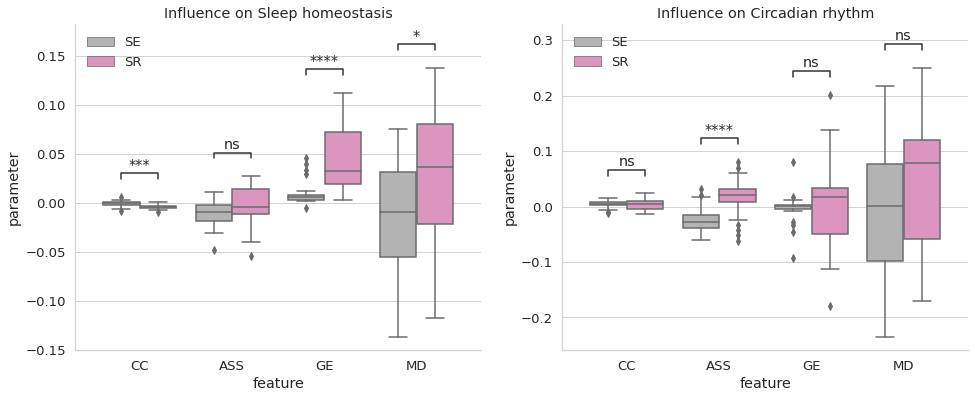

In [45]:
import statannot
sns.set(rc={"figure.figsize":(12, 6), 'axes.edgecolor': 'lightgrey', 'axes.facecolor':'None'}, font_scale=1.2)
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16,6))

df_box = pd.DataFrame(columns=['feature','parameter','hue'])
for k, v in {'CC':'Hparam_CC', 'ASS':'Hparam_ASS', 'GE':'Hparam_GE', 'MD':'Hparam_MD'}.items():
    for protocol in ['SE', 'SR']:
        df_box = pd.concat([df_box, pd.DataFrame({'feature': [k]*24, #number of subjects 
                                                  'parameter':pd.DataFrame(vars()[v][protocol]).iloc[1].tolist(),
                                                  'hue':[protocol]*24})], ignore_index=True)

sns.boxplot(ax=axes[0], x='feature', y='parameter', hue='hue', data=df_box, palette=[sns.color_palette('Set2')[-1],sns.color_palette('Set2')[3]]) #sns.color_palette().reverse()
axes[0], results = statannot.add_stat_annotation(
    axes[0],
    data=df_box,
    x='feature',
    y='parameter',
    hue='hue',
    box_pairs=[
        (("CC", "SE"), ("CC", "SR")),
        (("ASS", "SE"), ("ASS", "SR")),
        (("GE", "SE"), ("GE", "SR")),
        (("MD", "SE"), ("MD", "SR"))
    ],
    test="t-test_ind",
    comparisons_correction=None,    
    text_format="star",
    loc="inside",
)

df_box = pd.DataFrame(columns=['feature','parameter','hue'])
for k, v in {'CC':'Hparam_CC', 'ASS':'Hparam_ASS', 'GE':'Hparam_GE', 'MD':'Hparam_MD'}.items():
    for protocol in ['SE', 'SR']:
        df_box = pd.concat([df_box, pd.DataFrame({'feature': [k]*24, #number of subjects 
                                                  'parameter':pd.DataFrame(vars()[v][protocol]).iloc[2].tolist(),
                                                  'hue':[protocol]*24})], ignore_index=True)

sns.boxplot(ax=axes[1], x='feature', y='parameter', hue='hue', data=df_box, palette=[sns.color_palette('Set2')[-1],sns.color_palette('Set2')[3]])
axes[1], results = statannot.add_stat_annotation(
    axes[1],
    data=df_box,
    x='feature',
    y='parameter',
    hue='hue',
    box_pairs=[
        (("CC", "SE"), ("CC", "SR")),
        (("ASS", "SE"), ("ASS", "SR")),
        (("GE", "SE"), ("GE", "SR")),
        (("MD", "SE"), ("MD", "SR"))
    ],
    test="t-test_ind",
    comparisons_correction=None,
    text_format="star",
    loc="inside",
)

axes[0].set_title("Influence on Sleep homeostasis")
axes[1].set_title("Influence on Circadian rhythm")
axes[0].grid(True, axis='y', color='lightgrey'); axes[1].grid(True, axis='y', color='lightgrey')
axes[0].legend(frameon=False); axes[1].legend(frameon=False)
#plt.savefig('../results/SR_lme.png', dpi=300)
sns.despine()

### Dynamics in network topological features